# Kaggle 타이타닉 생존자 예측 2 - Feature Engineering

사실 데이터 분석 프로젝트라는게 교과서적으로  
EDA > Feature Engineering > Modeling > Validation > Application 뭐 이렇게 딱 정해진 순서로 가야한다는 법은 없다.  

기본적인 흐름이 그렇다는 것이지, 각 단계들은 상호보완적으로 이루어진다고 생각한다.  
모델링을 하다보니 feature 재가공이 필요할 수도 있고 다시 EDA부터 시작해야되는 상황이 올 수도 있다.  
  

일단 튜토리얼이라고 생각하고 적당히 단계를 밟아 결과를 내보는 것을 목표로 해보자.  
기본적으로 전처리 작업이 필요한 것들과 필요할 수도 있을 것들을 정리해보자.  

- Name 컬럼 텍스트 추출해보기
- 결측치, 이상치 처리?(Age, Embarked, Cabin)
- 범주형 변수 생성 (문자 -> 숫자, dummy, 구간분할 등)
- 값 매핑?  

In [229]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

mydir = r'D:\Python\kaggle\titanic\\'
train = pd.read_csv(mydir + "train.csv", dtype=str)
train['Survived'] = train['Survived'].astype(int)
test = pd.read_csv(mydir + "test.csv", dtype=str)

## 1. 텍스트 전처리(Name)  

승객 이름의 정보에서 Mr., Miss. 등의 정보를 [정규표현식](https://yganalyst.github.io/study/memo_6/)을 이용해서 추출한다.  

In [205]:
train['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [206]:
train['Name_fix'] = train['Name'].str.extract('( [A-Z]+\w*)', expand=False).str.strip()

In [207]:
train['Name_fix'].value_counts()

Mr             503
Miss           179
Mrs            121
Master          40
Dr               7
Rev              6
Impe             3
Planke           3
Mlle             2
Gordon           2
Col              2
Major            2
Castellana       2
Jonkheer         1
Velde            1
Messemaeker      1
Don              1
Cruyssen         1
Capt             1
Manent           1
Shawah           1
Countess         1
Steen            1
Ms               1
Walle            1
Mulder           1
Billiard         1
More             1
Melkebeke        1
Carlo            1
Mme              1
Pelsmaeker       1
Name: Name_fix, dtype: int64

언급된 영어이름 호칭에 대한 검색을 해보았다.  
 - Mr. : 성인 남성
 - Mrs. : 결혼을 한 여성
 - Ms. : 결혼 여부를 밝히고 싶지 않을 때 사용하는 여성 호칭
 - Miss : 결혼을 하지 않은 여성
 - Master (Mstr.) : 결혼을 하지 않은 남성. 주로 청소년 이하
 - Dr : 의사
 
출처 : https://romanegloo.wordpress.com/tag/mr-ms-mrs-miss-mstr-%ED%98%B8%EC%B9%AD/  

위의 5가지가 승객들의 이름에 대부분을 차지한다.  

Master 까지만 유지하고 이후의 데이터 들은 모두 Others라는 카테고리로 처리하자.  

In [208]:
train['Name_fix'] = np.where(train['Name_fix'].isin(['Mr','Miss','Mrs','Master']), train['Name_fix'], 'Others')
train['Name_fix'].value_counts()

Mr        503
Miss      179
Mrs       121
Others     48
Master     40
Name: Name_fix, dtype: int64

각 Name 카테고리별 생존확률은 다음과 같다.  

In [209]:
train.groupby(['Name_fix'])['Survived'].mean()

Name_fix
Master    0.575000
Miss      0.703911
Mr        0.157058
Mrs       0.801653
Others    0.354167
Name: Survived, dtype: float64

<Figure size 504x432 with 0 Axes>

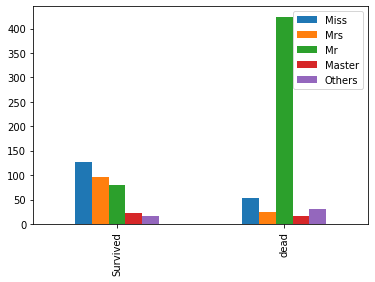

In [210]:
def bar_df(df,colname):
    surv = df[df['Survived']==1][colname].value_counts()
    dead = df[df['Survived']==0][colname].value_counts()
    tt = pd.DataFrame([surv,dead], index=['Survived','dead'])
    return tt

plt.figure(figsize=(7,6))
bar_df(train,'Name_fix').plot(kind='bar')
plt.show()

성인남성의 경우 전체 승객 대비 60% 이상에 분포하고 있었는데, 실제로 살아남은 승객이 많지 않은 것 같다.  

test 데이터도 마찬가지의 처리를 해준다.  

In [211]:
test['Name_fix'] = test['Name'].str.extract('( [A-Z]+\w*)', expand=False).str.strip()
test['Name_fix'] = np.where(test['Name_fix'].isin(['Mr','Miss','Mrs','Master']), test['Name_fix'], 'Others')

## 2. 결측치 처리(Age, Embarked)  

### 2-1. Age  

아까 생성했던 Name_fix컬럼의 그룹별 중앙값 나이로 결측치를 보완하자.   

In [212]:
for ls_df in [train, test]:
    ls_df['Age'] = ls_df['Age'].astype(float)
    ls_df['Age_median'] = ls_df.groupby(['Name_fix'])['Age'].transform('median')
    ls_df['Age'] = np.where(ls_df['Age'].isnull(), ls_df['Age_median'], ls_df['Age'])

### 2-2. Embarked  

Embarked 같은 경우 결측치가 2개 밖에 없는데, [EDA](https://yganalyst.github.io/project/kaggle_titanic_1/)에서 살펴 본 것 처럼 약 72%가 Southampton에 해당하기 때문에 결측값으로 그냥 넣어주기로 하자.  


In [213]:
train['Embarked'].fillna("S", inplace=True)

### 2-3. Fare  

test 데이터에는 Fare컬럼에 1개의 결측치가 존재한다.  
우선 단순하게 Pclass별 Fare의 중앙값으로 대체해 주기로하자.  

In [214]:
test['Fare'] = test['Fare'].astype(float) 

In [215]:
test['Fare_median'] = test.groupby(['Pclass'])['Fare'].transform('median')
test['Fare'] = np.where(test['Fare'].isnull(), test['Fare_median'], test['Fare'])

## 3. 파생변수 생성 (Age, SibSp & Parch)  

### 3-1. 범주형 변수 변환(binning)    

연령대의 경우 0세 - 80세 까지 넓은 연령층이 분포하고 있고 20대 - 40대 사이가 대부분을 차지하고 있었기 때문에, scale을 고르게 조절해주어 왜곡을 보정해줄 수 있다.  
연속형 변수의 범주형 변수 변환으로 Binning이라고도 한다([참고](https://yganalyst.github.io/study/Pd_7/)).  
  
  
왜곡을 보정함과 동시에 원천 데이터의 손실시키는 단점도 존재한다.  

In [216]:
bins = [0, 16, 32, 48, 64, 81]  # 나이대 경계점
bin_names = ['child','young','adult','middle','senior'] # 라벨
train['Age_bin'] = pd.cut(train['Age'],
                          bins = bins,
                          labels=bin_names,
                          include_lowest = True)
train['Age_bin'].value_counts()

young     499
adult     208
child     104
middle     69
senior     11
Name: Age_bin, dtype: int64

<Figure size 504x432 with 0 Axes>

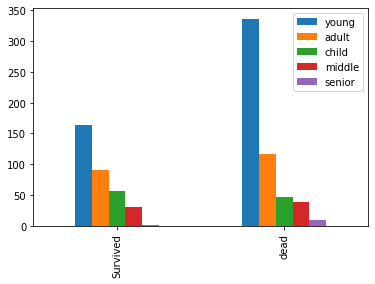

In [217]:
plt.figure(figsize=(7,6))
bar_df(train,'Age_bin').plot(kind='bar')
plt.show()

In [218]:
test['Age_bin'] = pd.cut(test['Age'],
                          bins = bins,
                          labels=bin_names,
                          include_lowest = True)

### 3-2. 가족 구성원 수 (SibSp & Parch)  

 - SibSp : 동반한 형제자매, 배우자 수 
 - Parch : 동반한 부모, 자식 수  
 
위 두 컬럼을 합하여 해당 승객이 속한 가족구성원의 총 수를 구하여 새로운 파생변수를 생성하자.  

In [219]:
train['Family_cnt'] = train['SibSp'].astype(int) + train['Parch'].astype(int)

<Figure size 504x432 with 0 Axes>

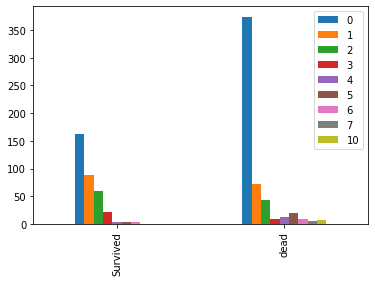

In [220]:
plt.figure(figsize=(7,6))
bar_df(train,'Family_cnt').plot(kind='bar')
plt.show()

In [221]:
test['Family_cnt'] = test['SibSp'].astype(int) + test['Parch'].astype(int)

## 4. Feature추출 및 매핑  

1차적인 전처리가 마무리 되었다고 가정하고, 사용할 Feature만 추려보자.  

In [222]:
feature_1 = ['Survived','Pclass','Sex','Age_bin','Family_cnt','Fare','Embarked','Name_fix']

In [223]:
train = train[feature_1].copy()
test = test[feature_1[1:]].copy()

In [224]:
train

,Survived,Pclass,Sex,Age_bin,Family_cnt,Fare,Embarked,Name_fix
0,0,3,male,young,1,7.25,S,Mr
1,1,1,female,adult,1,71.2833,C,Mrs
2,1,3,female,young,0,7.925,S,Miss
3,1,1,female,adult,1,53.1,S,Mrs
4,0,3,male,adult,0,8.05,S,Mr
...,...,...,...,...,...,...,...,...
886,0,2,male,young,0,13,S,Others
887,1,1,female,young,0,30,S,Miss
888,0,3,female,young,3,23.45,S,Miss
889,1,1,male,young,0,30,C,Mr


학습 모델에 학습을 시킬 데이터는 모두 숫자형 데이터이어야 한다.  
현재 문자형 처리 되어있는 Sex, Age_bin, Embarked, Name_fix 변수를 숫자형으로 처리해주자.  

In [225]:
sex = {'male':1, 'female':2}
age_bin = {'child':1, 'young':2,'adult':3, 'middle':4, 'senior':5}
embarked = {'C':1,'Q':2,'S':3}
name_fix = {'Mr':1,'Mrs':2,'Miss':3,'Master':4,'Others':5}

In [226]:
for df_ls in [train, test]:
    df_ls.replace({"Sex": sex}, inplace=True)
    df_ls.replace({"Age_bin": age_bin}, inplace=True)
    df_ls.replace({"Embarked": embarked}, inplace=True)
    df_ls.replace({"Name_fix": name_fix}, inplace=True)

In [227]:
train

,Survived,Pclass,Sex,Age_bin,Family_cnt,Fare,Embarked,Name_fix
0,0,3,1,2,1,7.25,3,1
1,1,1,2,3,1,71.2833,1,2
2,1,3,2,2,0,7.925,3,3
3,1,1,2,3,1,53.1,3,2
4,0,3,1,3,0,8.05,3,1
...,...,...,...,...,...,...,...,...
886,0,2,1,2,0,13,3,5
887,1,1,2,2,0,30,3,3
888,0,3,2,2,3,23.45,3,3
889,1,1,1,2,0,30,1,1


In [228]:
test

,Pclass,Sex,Age_bin,Family_cnt,Fare,Embarked,Name_fix
0,3,1,3,0,7.8292,2,1
1,3,2,3,1,7.0000,3,2
2,2,1,4,0,9.6875,2,1
3,3,1,2,0,8.6625,3,1
4,3,2,2,2,12.2875,3,2
...,...,...,...,...,...,...,...
413,3,1,2,0,8.0500,3,1
414,1,2,3,0,108.9000,1,5
415,3,1,3,0,7.2500,3,1
416,3,1,2,0,8.0500,3,1


이 데이터를 가지고 모델링 단계를 진행해보면서 몇가지 알고리즘에 학습시켜 보도록 하자.  